In [1]:
## Notebook env: mirtud_env (mirtud_env kernel)
import numpy as np
import pandas as pd
import scanpy as sc
%load_ext rpy2.ipython



In [2]:
## get PC scores for each cell from miR expression data (after normalization) and add to cell metadata
adata = sc.read('/home/ssobti/projects/mir_tud/010523_filtered_data/miR.integrated.qc_norm_scaled.dimred.clustered.gex.guide_assigned.h5ad')
PCA_coordinates = adata.obsm['X_pca']
PCA_coordinates = pd.DataFrame(PCA_coordinates)
meta = adata.obs

Only considering the two last: ['.guide_assigned', '.h5ad'].
Only considering the two last: ['.guide_assigned', '.h5ad'].


/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [3]:
%%R
library(Seurat)

## get R version of PCA coordinates that have weights
adata.R = readRDS('/home/ssobti/projects/mir_tud/010523_filtered_data/miR_normalized_integrated_seurat.rds')



    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 
Attaching SeuratObject


In [7]:
%%R
scaled_scores <- scale(Embeddings(adata.R, reduction = "pca"))
var_rot <- varimax(Loadings(adata.R, reduction = "pca"))$rotmat
rotated_varimax_scores <- scaled_scores %*% var_rot

In [9]:
%%R
vari_weights = varimax(Loadings(adata.R, reduction = "pca"))
vari_weights = vari_weights$loadings
vari_weights[1:5,1:5]

              PC_1        PC_2         PC_3          PC_4          PC_5
IFIT2 -0.010907453 0.002815424  0.011872409 -0.0044128251 -0.0038884464
IFIT3 -0.003904446 0.007061878  0.007961426  0.0000171365 -0.0037172346
IFIT1  0.005096107 0.001910319  0.000452338 -0.0060331203  0.0008821542
OASL  -0.003059867 0.004559411  0.019185094  0.0017159237 -0.0014871808
CDH1  -0.001087855 0.002699645 -0.006597429  0.0058225829  0.0020660979


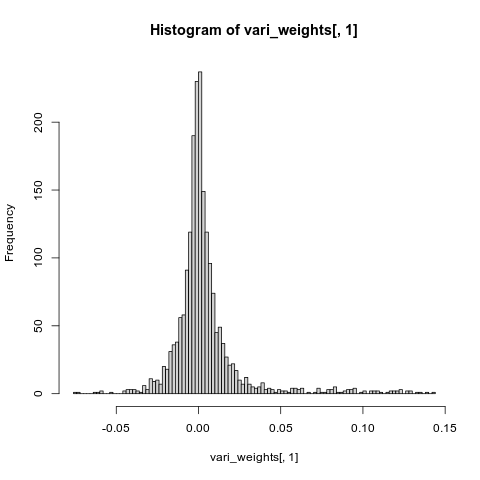

In [11]:
%%R
## genes with high weights in PC1 from varimax rotation
hist(vari_weights[,1], breaks = 100)

In [10]:
%%R
Loadings(adata.R, reduction = "pca")[1:5,1:5]

               PC_1         PC_2         PC_3         PC_4        PC_5
IFIT2 -0.0107247862 0.0028673839 -0.025863680  0.028834071 0.125721377
IFIT3 -0.0061436897 0.0068719929 -0.028691374  0.032303948 0.134758755
IFIT1  0.0008485248 0.0004857165 -0.038396580  0.026113763 0.132967890
OASL  -0.0016329590 0.0004698825 -0.039277763  0.033572478 0.127760928
CDH1  -0.0017171896 0.0021763820  0.003233268 -0.000594705 0.003938942


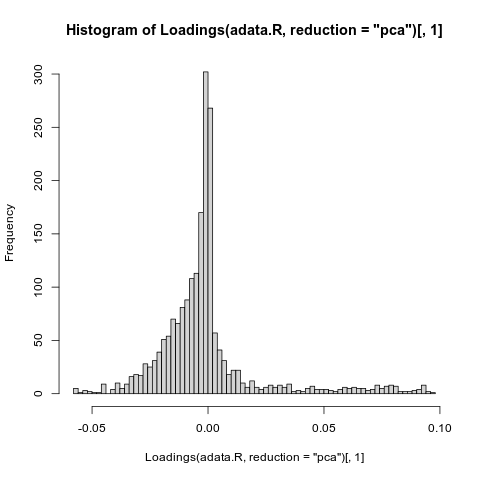

In [12]:
%%R
## genes with high weights in PC1 from original PCA
hist(Loadings(adata.R, reduction = "pca")[,1], breaks = 100)

In [3]:
%%R -i PCA_coordinates,meta
## make linear model between PC scores and cell guide identity, pick best fit model for each PC from log likelihood ratio test p-value
uniq = unique(meta$guide)
fitted_models = list()
fit_pvals = list()
pb = txtProgressBar(min = 0, max = ncol(PCA_coordinates), style = 3)
for (j in 1:ncol(PCA_coordinates)){
    fitted_models[[j]] <- lapply(as.list(uniq), function(x) glm(identity ~ scores, data = data.frame(scores = PCA_coordinates[,j], identity = factor(meta$guide == x)), family = 'binomial'))
    fit_pvals[[j]] = lapply(fitted_models[[j]], function(x) with(x, pchisq(null.deviance - deviance, df.null - df.residual, lower.tail = FALSE)))
    setTxtProgressBar(pb, j)
}
close(pb)


  |======================================================================| 100%


In [4]:
%%R
fit_pvals_adj = lapply(fit_pvals, function(x) p.adjust(as.numeric(unlist(x))))
fit_pvals_adj = lapply(fit_pvals_adj, function(x) -log10(x))
df = data.frame(matrix(unlist(fit_pvals_adj), nrow = length(fit_pvals_adj), byrow = T))

In [5]:
%%R
library(tidyr)
colnames(df) = uniq
df$y = paste0('PC', 1:ncol(PCA_coordinates))
df_long <- pivot_longer(df, cols = -c(y), names_to = 'x', values_to = 'value')
d <- as.data.frame(df_long)
head(d)

    y               x value
1 PC1 hsa-miR-203a-3p     0
2 PC1   hsa-miR-93-3p     0
3 PC1 hsa-miR-130b-3p     0
4 PC1       TuD_NC_18     0
5 PC1 hsa-miR-147b-5p     0
6 PC1  hsa-miR-501-5p     0


In [6]:
%%R
save(fitted_models, fit_pvals, fit_pvals_adj, file = '/home/ssobti/projects/mir_tud/output_data/genexp_pathway/PC_scores/miR_logit_fit_data.RData')

In [3]:
%%R -i PCA_coordinates,meta
load('/home/ssobti/projects/mir_tud/output_data/genexp_pathway/PC_scores/miR_logit_fit_data.RData')

In [4]:
%%R
library(tidyr)
uniq = unique(meta$guide)
df = data.frame(matrix(unlist(fit_pvals_adj), nrow = length(fit_pvals_adj), byrow = T))
colnames(df) = uniq
df$y = paste0('PC', 1:ncol(PCA_coordinates))
df_long <- pivot_longer(df, cols = -c(y), names_to = 'x', values_to = 'value')
d <- as.data.frame(df_long)
head(d)

    y               x value
1 PC1 hsa-miR-203a-3p     0
2 PC1   hsa-miR-93-3p     0
3 PC1 hsa-miR-130b-3p     0
4 PC1       TuD_NC_18     0
5 PC1 hsa-miR-147b-5p     0
6 PC1  hsa-miR-501-5p     0


In [5]:
%%R
gene_cluster = d
colnames(gene_cluster) = c('cluster', 'Gene', 'count')

In [6]:
%%R
library(ggplot2)
library(tidyr)
library(cowplot)
library(aplot)
library(patchwork)
library(ggtree)
library(dplyr)


Attaching package: ‘patchwork’

The following object is masked from ‘package:cowplot’:

    align_plots

ggtree v3.6.0 For help: https://yulab-smu.top/treedata-book/

If you use the ggtree package suite in published research, please cite
the appropriate paper(s):

Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam.
ggtree: an R package for visualization and annotation of phylogenetic
trees with their covariates and other associated data. Methods in
Ecology and Evolution. 2017, 8(1):28-36. doi:10.1111/2041-210X.12628

Guangchuang Yu. Using ggtree to visualize data on tree-like structures.
Current Protocols in Bioinformatics. 2020, 69:e96. doi:10.1002/cpbi.96

S Xu, Z Dai, P Guo, X Fu, S Liu, L Zhou, W Tang, T Feng, M Chen, L
Zhan, T Wu, E Hu, Y Jiang, X Bo, G Yu. ggtreeExtra: Compact
visualization of richly annotated phylogenetic data. Molecular Biology
and Evolution. 2021, 38(9):4039-4042. doi: 10.1093/molbev/msab166

Attaching package: ‘ggtree’

The following objec

In [7]:
%%R

# make data square to calculate euclidean distance
mat <- gene_cluster %>% # drop unused columns to faciliate widening
  pivot_wider(names_from = cluster, values_from = count) %>% 
  data.frame() # make df as tibbles -> matrix annoying
row.names(mat) <- mat$Gene  # put gene in `row`
mat <- mat[,-1] #drop gene column as now in rows
clust <- hclust(dist(mat %>% as.matrix())) 
v_clust <- hclust(dist(mat %>% as.matrix() %>% t())) # hclust with distance matrix
############ NOTICE THE t() above)

ddgram_col <- as.dendrogram(v_clust)
ggtree_plot_col <- ggtree(ddgram_col) + layout_dendrogram()

dotplot <- gene_cluster %>% 
  mutate(Gene = factor(Gene, levels = clust$labels[clust$order]),
         cluster = factor(cluster, levels = v_clust$labels[v_clust$order])) %>%
         filter(count > 0) %>%
  ggplot(aes(x=cluster, y = Gene, color = count, size = count)) + 
  geom_point() + 
  cowplot::theme_cowplot() + 
  theme(axis.line  = element_blank()) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
  ylab('') +
  theme(axis.ticks = element_blank()) +
  scale_color_gradientn(colours = viridis::viridis(20), limits = c(0,4), oob = scales::squish, name = '-Log10(P-value)') +
  scale_size_continuous(name = '-Log10(P-value)') +
  scale_y_discrete(position = "right")
#################################################
ggtree_plot_col <- ggtree_plot_col + xlim2(dotplot)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


the plot was flipped and the x limits will be applied to y-axis


In [8]:
%%R
ddgram <- as.dendrogram(clust) # create dendrogram
ggtree_plot <- ggtree::ggtree(ddgram)
ggtree_plot <- ggtree_plot + ylim2(dotplot)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


In [9]:
%%R
labels <- ggplot(gene_cluster %>% 
                   mutate(`Cell Type` = rep('A', nrow(gene_cluster)),
                           cluster = factor(cluster, levels = v_clust$labels[v_clust$order])), 
                 aes(x = cluster, y = 1, fill = `Cell Type`)) + 
  geom_tile() + 
  scale_fill_brewer(palette = 'Set1') + 
  theme_nothing() +
  xlim2(dotplot)

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 8337 rows containing missing values (`geom_tile()`). 



In addition: Warning message:
Removed 8337 rows containing missing values (`geom_tile()`). 


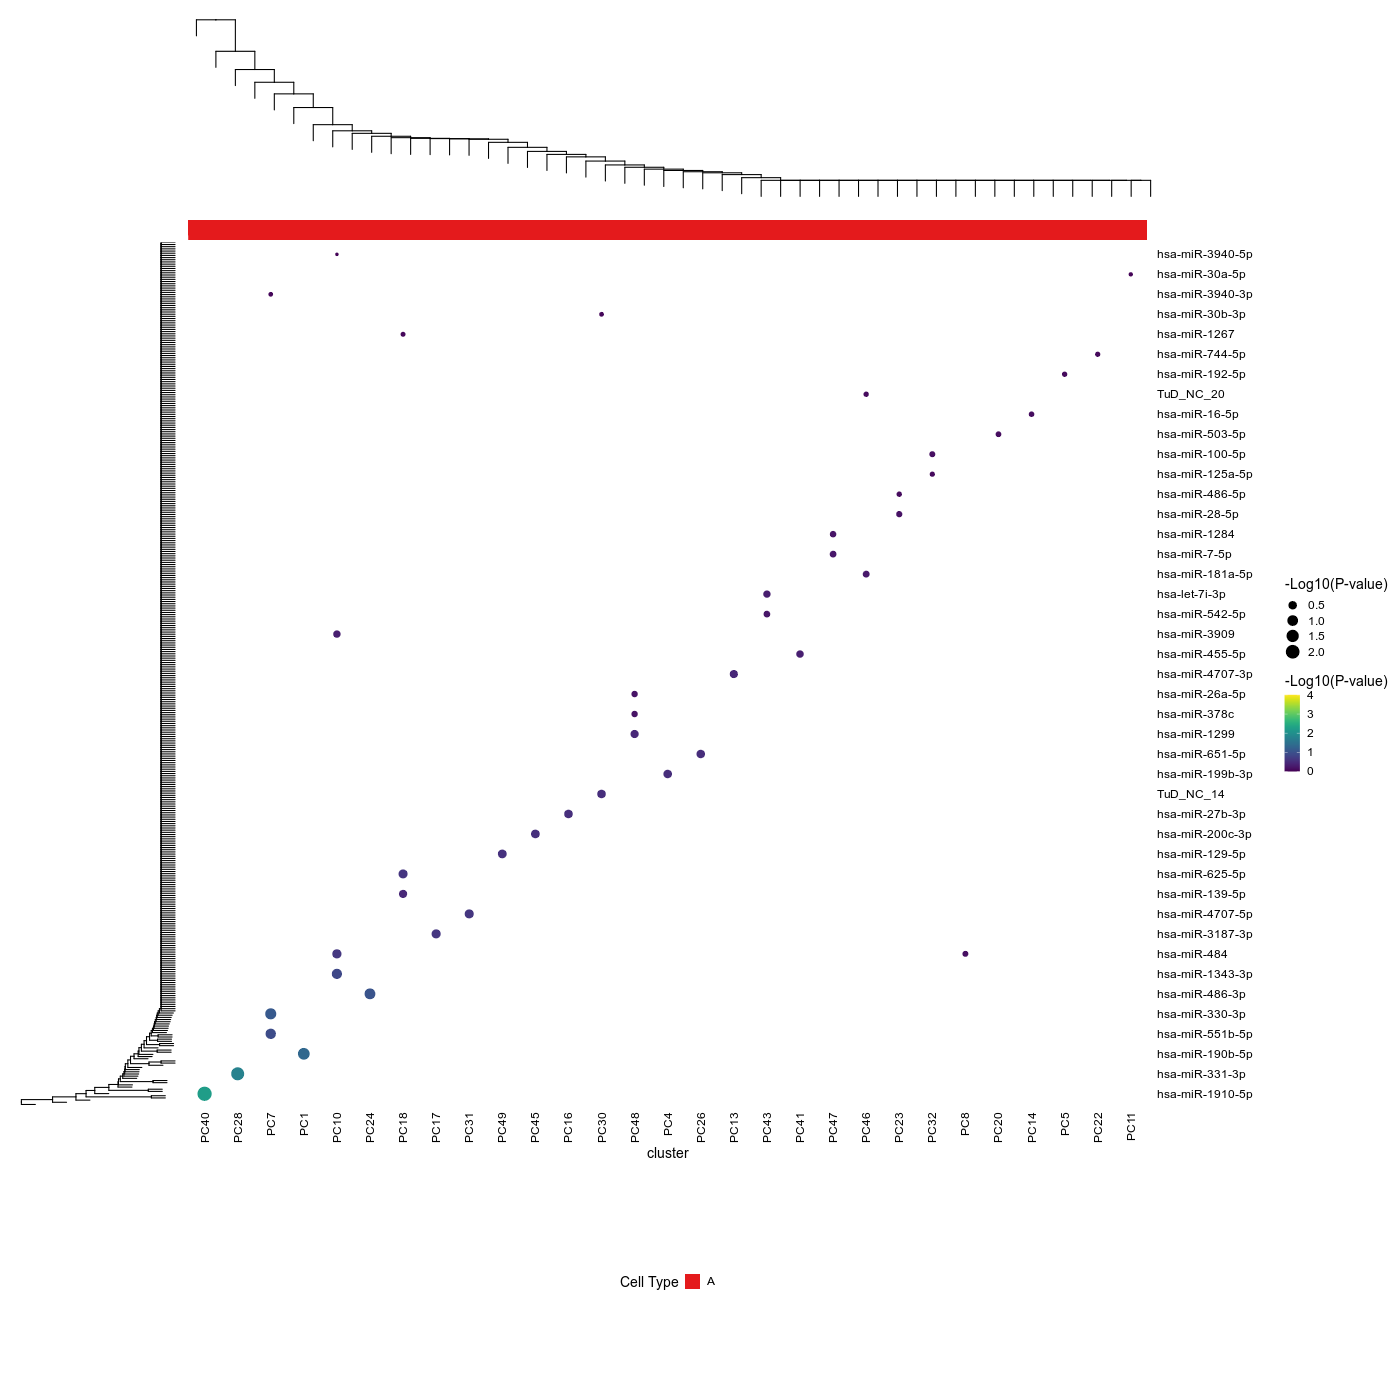

In [10]:
%%R -w 1400 -h 1400

legend <- plot_grid(get_legend(labels + theme(legend.position="bottom")))

plot_spacer() + plot_spacer() + ggtree_plot_col +
  plot_spacer() + plot_spacer() + labels +
  plot_spacer() + plot_spacer() + plot_spacer() +
  ggtree_plot + plot_spacer() + dotplot + 
  plot_spacer() + plot_spacer() + legend + 
  plot_layout(ncol = 3, widths = c(0.7, -0.1, 4), heights = c(0.9, 0.1, -0.1, 4, 1))

## FDR corrected p-values (instead of Holm corrected above) ##

In [11]:
%%R
fit_pvals_adj = lapply(fit_pvals, function(x) p.adjust(as.numeric(unlist(x)), method = 'BH'))
fit_pvals_adj = lapply(fit_pvals_adj, function(x) -log10(x))

In [12]:
%%R
library(tidyr)
uniq = unique(meta$guide)
df = data.frame(matrix(unlist(fit_pvals_adj), nrow = length(fit_pvals_adj), byrow = T))
colnames(df) = uniq
df$y = paste0('PC', 1:ncol(PCA_coordinates))
df_long <- pivot_longer(df, cols = -c(y), names_to = 'x', values_to = 'value')
d <- as.data.frame(df_long)
head(d)

    y               x      value
1 PC1 hsa-miR-203a-3p 0.02135172
2 PC1   hsa-miR-93-3p 0.02163365
3 PC1 hsa-miR-130b-3p 0.03007732
4 PC1       TuD_NC_18 0.04731496
5 PC1 hsa-miR-147b-5p 0.03007732
6 PC1  hsa-miR-501-5p 0.02205562


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 15880 rows containing missing values (`geom_tile()`). 



the plot was flipped and the x limits will be applied to y-axis
In addition: Warning message:
Removed 15880 rows containing missing values (`geom_tile()`). 


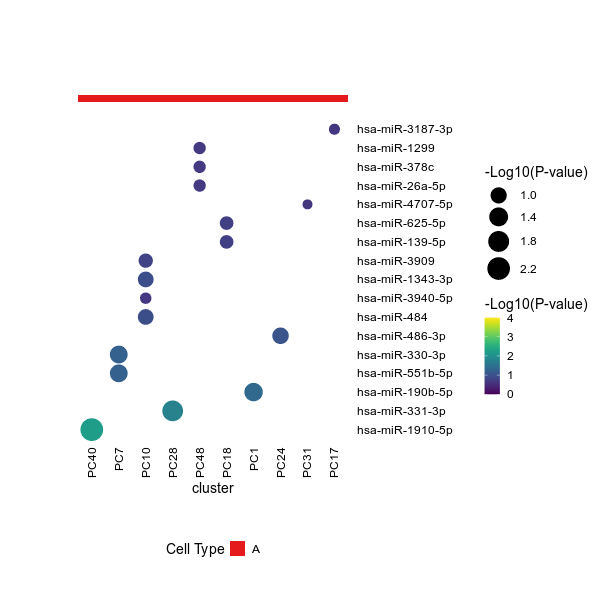

In [18]:
%%R -w 600 -h 600
gene_cluster = d
colnames(gene_cluster) = c('cluster', 'Gene', 'count')

# make data square to calculate euclidean distance
mat <- gene_cluster %>% # drop unused columns to faciliate widening
  pivot_wider(names_from = cluster, values_from = count) %>%
  data.frame() # make df as tibbles -> matrix annoying
row.names(mat) <- mat$Gene  # put gene in `row`
mat <- mat[,-1] #drop gene column as now in rows
clust <- hclust(dist(mat %>% as.matrix())) 
v_clust <- hclust(dist(mat %>% as.matrix() %>% t())) # hclust with distance matrix
############ NOTICE THE t() above)

ddgram_col <- as.dendrogram(v_clust)
ggtree_plot_col <- ggtree(ddgram_col) + layout_dendrogram()

dotplot <- gene_cluster %>% 
  mutate(Gene = factor(Gene, levels = clust$labels[clust$order]),
         cluster = factor(cluster, levels = v_clust$labels[v_clust$order])) %>%
         filter(count > (-log10(0.25))) %>%
  ggplot(aes(x=cluster, y = Gene, color = count, size = count)) + 
  geom_point() + 
  cowplot::theme_cowplot() + 
  theme(axis.line  = element_blank()) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
  ylab('') +
  theme(axis.ticks = element_blank()) +
  scale_color_gradientn(colours = viridis::viridis(20), limits = c(0,4), oob = scales::squish, name = '-Log10(P-value)') +
  scale_size_continuous(name = '-Log10(P-value)', range = c(4,10)) +
  scale_y_discrete(position = "right")
#################################################
ggtree_plot_col <- ggtree_plot_col + xlim2(dotplot)


ddgram <- as.dendrogram(clust) # create dendrogram
ggtree_plot <- ggtree::ggtree(ddgram)
ggtree_plot <- ggtree_plot + ylim2(dotplot)

labels <- ggplot(gene_cluster %>% 
                   mutate(`Cell Type` = rep('A', nrow(gene_cluster)),
                           cluster = factor(cluster, levels = v_clust$labels[v_clust$order])), 
                 aes(x = cluster, y = 1, fill = `Cell Type`)) + 
  geom_tile() + 
  scale_fill_brewer(palette = 'Set1') + 
  theme_nothing() +
  xlim2(dotplot)

legend <- plot_grid(get_legend(labels + theme(legend.position="bottom")))

plot_spacer() + plot_spacer() + plot_spacer() +
  plot_spacer() + plot_spacer() + labels +
  plot_spacer() + plot_spacer() + plot_spacer() +
  plot_spacer() + plot_spacer() + dotplot + 
  plot_spacer() + plot_spacer() + legend + 
  plot_layout(ncol = 3, widths = c(0.7, -0.1, 4), heights = c(0.9, 0.1, -0.1, 4, 1))

In [19]:
%%R
ggsave('/home/ssobti/projects/mir_tud/output_data/genexp_pathway/PC_scores/miR_logit_fit_plot.pdf', width = 14, height = 14)

In addition: Warning message:
Removed 15880 rows containing missing values (`geom_tile()`). 


In [ ]:
%%R

## graph the miRs in the clusters and pick out those with positive correlations (ie PC scores associated with that particular miR)
